In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE  # For balancing data


In [4]:
# Load dataset
file_path = '/content/drive/MyDrive/Minor_project6thsem/Datasets/DDOS SDN TREE TORUS /DDoS-SDN-Torus.csv'
df = pd.read_csv(file_path, low_memory=False)


<ipython-input-142-b997d77631fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="coolwarm")


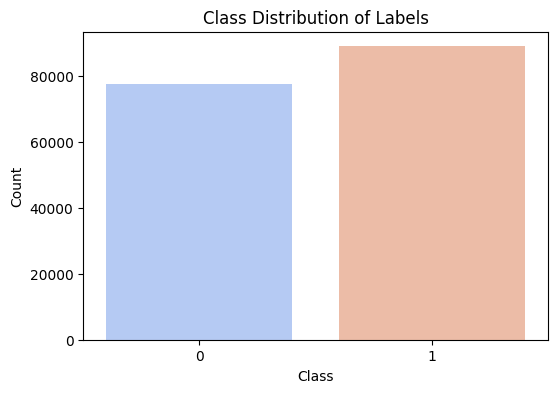

In [ ]:
# Visualize Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Class Distribution of Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Epoch [1/30], Loss: 0.6948
Epoch [2/30], Loss: 0.6850
Epoch [3/30], Loss: 0.6750
Epoch [4/30], Loss: 0.6645
Epoch [5/30], Loss: 0.6534
Epoch [6/30], Loss: 0.6415
Epoch [7/30], Loss: 0.6288
Epoch [8/30], Loss: 0.6147
Epoch [9/30], Loss: 0.5996
Epoch [10/30], Loss: 0.5832
Epoch [11/30], Loss: 0.5655
Epoch [12/30], Loss: 0.5457
Epoch [13/30], Loss: 0.5259
Epoch [14/30], Loss: 0.5040
Epoch [15/30], Loss: 0.4810
Epoch [16/30], Loss: 0.4578
Epoch [17/30], Loss: 0.4326
Epoch [18/30], Loss: 0.4084
Epoch [19/30], Loss: 0.3820
Epoch [20/30], Loss: 0.3558
Epoch [21/30], Loss: 0.3306
Epoch [22/30], Loss: 0.3049
Epoch [23/30], Loss: 0.2793
Epoch [24/30], Loss: 0.2555
Epoch [25/30], Loss: 0.2323
Epoch [26/30], Loss: 0.2098
Epoch [27/30], Loss: 0.1892
Epoch [28/30], Loss: 0.1704
Epoch [29/30], Loss: 0.1525
Epoch [30/30], Loss: 0.1361
 Model Accuracy: 0.9865

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     17800
           

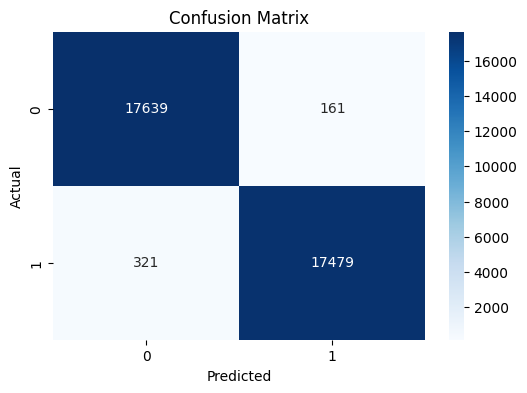

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE  # For handling class imbalance

# Load dataset
# df = pd.read_csv("your_dataset.csv")  # Uncomment if using a dataset

# Convert commas to dots & fix numeric conversion
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '.')  # Fix decimal format
    try:
        df[col] = df[col].astype(float)  # Convert to float if possible
    except ValueError:
        pass  # Skip non-numeric columns

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # One-hot encoding

# Label Encode target variable
if 'label' in df.columns:
    le = LabelEncoder()
    df_encoded['label'] = le.fit_transform(df['label'])

# Define features and target
X = df_encoded.drop(columns=['label'])
y = df_encoded['label']

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Define Improved Neural Network
class ImprovedFL_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedFL_Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize Model
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = ImprovedFL_Model(input_size, num_classes)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Lower LR & weight decay

# Train Model
epochs = 30  # Increased epochs
train_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate Model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1)

# Compute Accuracy
accuracy = accuracy_score(y_test, y_pred_classes.numpy())
print(f" Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes.numpy()))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes.numpy())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


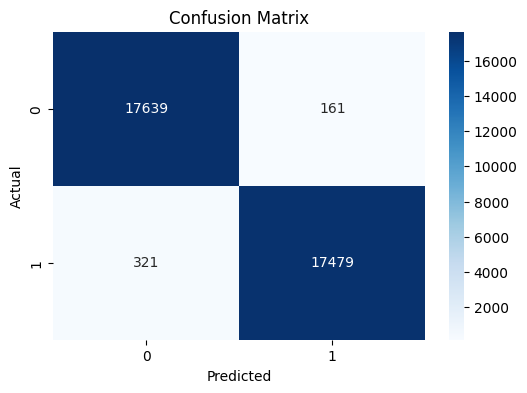

In [15]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes.numpy())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


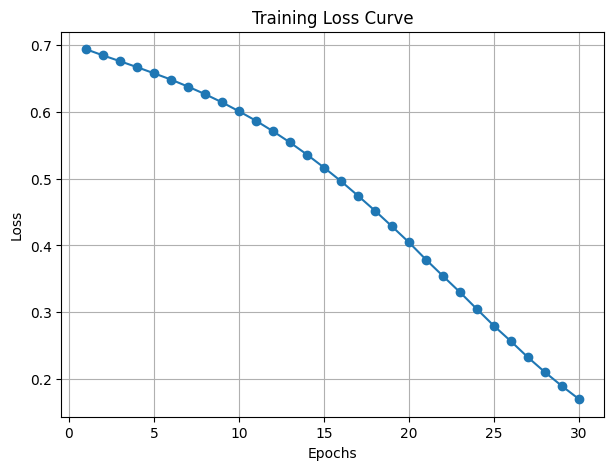

In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import shap

#  Loss Curve
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()





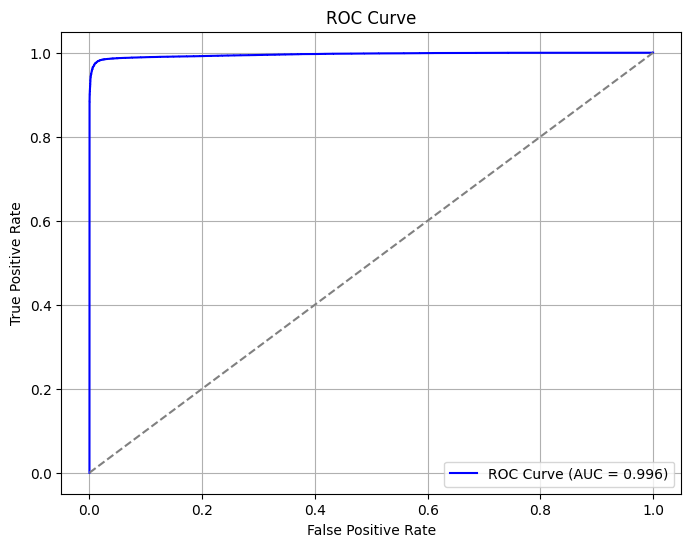

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Compute probabilities for ROC and Precision-Recall Curve
y_probs = torch.softmax(y_pred, dim=1)[:, 1].numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()



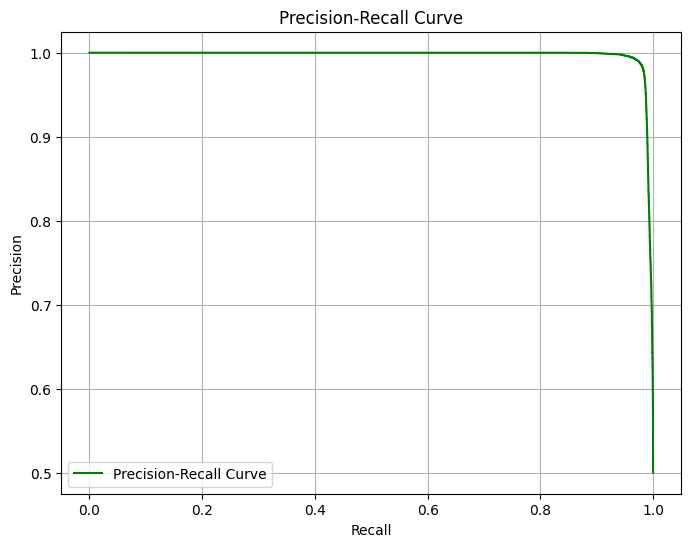

In [9]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

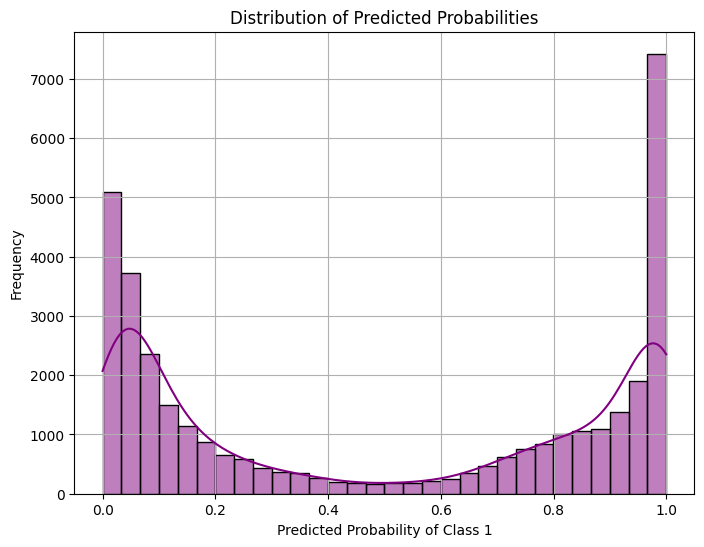

In [10]:

# Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_probs, bins=30, kde=True, color="purple")
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.grid()
plt.show()